In [1]:
import re

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_train = pd.read_csv("train.csv")
raw_test = pd.read_csv("test_with_solutions.csv", encoding="utf-8")

raw_train.head()

,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


In [3]:
def drop_noise(sentence):
    sentence.strip()
    PATTERN = r'[^a-zA-Z0-9 ]'
    filtered_sentence = re.sub(PATTERN, r'', sentence)
    return filtered_sentence

In [4]:
def clean(text, stopword_list):
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [5]:
train = raw_train.copy()
test = raw_test.copy()

stopword_list = nltk.corpus.stopwords.words('english')

train_data = train['Comment'].apply(drop_noise)
train_data = train_data.apply(lambda x: clean(x, stopword_list))

test_data = test['Comment'].apply(drop_noise)
test_data = test_data.apply(lambda x: clean(x, stopword_list))

train_data.head()

0                                         You fuck dad
1    really dont understand pointxa0 It seems mixin...
2    Axc2xa0majority Canadians wrong againnnUnless ...
3    listen dont wan na get married man women DONT ...
4    Cxe1c bu1ea1n xuu1ed1ng u0111u01b0u1eddng biu1...
Name: Comment, dtype: object

In [6]:
def ohfunc(classno):
    oh = [0, 0]
    oh[classno] = 1
    return np.array(oh)
train_labels = np.array(train["Insult"].apply(ohfunc).tolist())
test_labels = np.array(test["Insult"].apply(ohfunc).tolist())
#test_labels = np.reshape(test_labels, newshape=(len(test_data), 2))
#train_labels = np.reshape(train_labels, newshape=(len(train_data), 2))

In [7]:
# Character Encoding.
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

unique_glyphs = Counter()
for _, comment in train_data.iteritems():
    unique_glyphs.update(comment)
    
print("Unique glyphs:", len(unique_glyphs))
print(unique_glyphs)

tokenizer = Tokenizer(
    char_level=True,
    filters=None,
    lower=False,
    num_words=len(unique_glyphs)
)

#train_data.apply(lambda x: len(x)).describe()

tokenizer.fit_on_texts(test_data)
sequences = tokenizer.texts_to_sequences(test_data)
test_data = pad_sequences(sequences, maxlen=130)

tokenizer.fit_on_texts(train_data)
sequences = tokenizer.texts_to_sequences(train_data)
train_data = pad_sequences(sequences, maxlen=130)


Unique glyphs: 63
Counter({' ': 72408, 'e': 46805, 'a': 30972, 'n': 29633, 't': 28815, 'o': 27426, 'i': 27304, 's': 26140, 'r': 23359, 'l': 20627, 'd': 14890, 'c': 14015, 'u': 13274, 'h': 12033, 'g': 11432, 'm': 10620, 'p': 9743, 'y': 8611, 'k': 6567, 'b': 6365, 'w': 5889, 'f': 5858, 'x': 4687, 'v': 4130, 'I': 3784, '0': 3617, 'T': 2805, 'A': 2783, 'S': 2329, 'O': 2202, 'E': 2153, 'N': 1826, 'H': 1705, '2': 1689, 'Y': 1600, 'R': 1556, 'L': 1540, 'C': 1412, 'W': 1379, 'D': 1345, '1': 1344, 'M': 1299, 'B': 1148, 'U': 1088, 'P': 1040, 'G': 1018, 'F': 902, '9': 736, 'j': 612, 'z': 591, '3': 577, 'K': 573, '8': 529, 'J': 440, '4': 420, 'q': 419, '6': 380, '5': 372, 'V': 279, '7': 261, 'Z': 109, 'X': 79, 'Q': 77})


In [8]:
from keras import metrics
from keras.layers import *
from keras.optimizers import *
from keras.models import Sequential

In [9]:
# Building the model
EPOCHS = 15
model = Sequential()
model.add(Embedding(len(unique_glyphs) + 1, 300, input_length=130))
model.add(LSTM(300))
model.add(Dropout(0.5))
model.add(Dense(120, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
adam_op = Adam(lr=0.004)
model.compile(loss='categorical_crossentropy', optimizer=adam_op,
             metrics=[metrics.categorical_accuracy])

In [10]:
history = model.fit(train_data, train_labels, 
                    batch_size=206, epochs=EPOCHS, verbose=1, 
                    validation_data=(test_data, test_labels))


Epoch 1/15
20/20 [==============================] - 28s 1s/step - loss: 0.7840 - categorical_accuracy: 0.6981 - val_loss: 0.5699 - val_categorical_accuracy: 0.7427
Epoch 2/15
20/20 [==============================] - 23s 1s/step - loss: 0.5680 - categorical_accuracy: 0.7330 - val_loss: 0.5752 - val_categorical_accuracy: 0.7499
Epoch 3/15
20/20 [==============================] - 29s 1s/step - loss: 0.5492 - categorical_accuracy: 0.7498 - val_loss: 0.5978 - val_categorical_accuracy: 0.7469
Epoch 4/15
20/20 [==============================] - 31s 2s/step - loss: 0.5484 - categorical_accuracy: 0.7520 - val_loss: 0.5542 - val_categorical_accuracy: 0.7499
Epoch 5/15
20/20 [==============================] - 30s 2s/step - loss: 0.5342 - categorical_accuracy: 0.7472 - val_loss: 0.5540 - val_categorical_accuracy: 0.7473
Epoch 6/15
20/20 [==============================] - 29s 1s/step - loss: 0.5342 - categorical_accuracy: 0.7569 - val_loss: 0.5681 - val_categorical_accuracy: 0.7465
Epoch 7/15
20/20

83/83 [==============================] - 10s 117ms/step - loss: 0.5903 - categorical_accuracy: 0.7473
0.7472610473632812


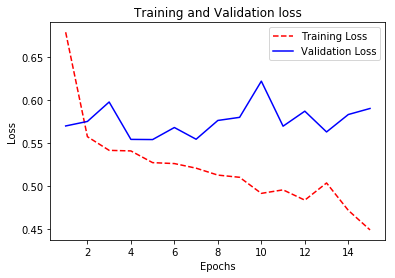

In [11]:
# Scoring and plotting model statistics.
score = model.evaluate(test_data, test_labels)
print(score[1])

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, EPOCHS + 1)
plt.plot(epochs, loss_train, 'r--', label="Training Loss")
plt.plot(epochs, loss_val, 'b-', label="Validation Loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()